# Performance Analysis for Parallel Burgers Solver

This notebook analyzes the parallel performance of the MPI-based Burgers equation solver.

## Performance Metrics

### 1. Speedup
$$S(P) = \frac{T(1)}{T(P)}$$
where $T(P)$ is execution time with $P$ processes.

**Ideal:** $S(P) = P$ (linear speedup)

### 2. Parallel Efficiency
$$E(P) = \frac{S(P)}{P} \times 100\%$$

**Ideal:** $E(P) = 100\%$

### 3. Karp-Flatt Metric
$$e = \frac{\frac{1}{S(P)} - \frac{1}{P}}{1 - \frac{1}{P}}$$

Estimates the serial fraction of code. **Lower is better** (< 0.1 indicates good parallelization).

## Data Sources

Load timing data from:
- `.npz` files generated by `2_parallel_rusanov.py` on PLGrid
- JSON files with pre-computed timing results

## Import Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import re
import os

# Configure matplotlib
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11

# Ensure output directory exists
os.makedirs('plots', exist_ok=True)

## Performance Analyzer Class

Core class for computing speedup, efficiency, and Karp-Flatt metrics.

In [2]:
class PerformanceAnalyzer:
    """Analyze parallel performance metrics."""

    def __init__(self):
        self.timing_data = {}  # {n_procs: elapsed_time}
        self.problem_size = None

    def add_timing(self, n_procs, elapsed_time):
        """Add timing result for a given number of processes."""
        self.timing_data[n_procs] = elapsed_time

    def load_from_npz_files(self, results_dir, grid_size):
        """
        Load timing results from .npz result files.
        
        Args:
            results_dir: Directory containing .npz files
            grid_size: Grid size to analyze (e.g., 300, 600, 1200)
        """
        results_path = Path(results_dir)
        pattern = f"burgers_nx{grid_size}_P*.npz"

        for result_file in results_path.glob(pattern):
            # Extract process count from filename
            match = re.search(r'P(\d+)\.npz', result_file.name)
            if match:
                n_procs = int(match.group(1))
                data = np.load(result_file)

                if 'elapsed_time' in data:
                    self.add_timing(n_procs, float(data['elapsed_time']))
                    if self.problem_size is None and 'nx' in data:
                        self.problem_size = int(data['nx'])

        if self.timing_data:
            print(f"Loaded timing data for {len(self.timing_data)} process counts")
        else:
            print(f"No timing data found for grid size {grid_size}")

    def compute_speedup(self):
        """Compute speedup: S(P) = T(1) / T(P)"""
        if 1 not in self.timing_data:
            raise ValueError("Sequential timing (P=1) required for speedup calculation")

        t_sequential = self.timing_data[1]
        speedup = {}

        for n_procs, t_parallel in self.timing_data.items():
            speedup[n_procs] = t_sequential / t_parallel

        return speedup

    def compute_efficiency(self):
        """Compute parallel efficiency: E(P) = S(P) / P * 100%"""
        speedup = self.compute_speedup()
        efficiency = {}

        for n_procs, s in speedup.items():
            efficiency[n_procs] = (s / n_procs) * 100.0

        return efficiency

    def compute_karp_flatt(self):
        """Compute Karp-Flatt metric: e = (1/S(P) - 1/P) / (1 - 1/P)"""
        speedup = self.compute_speedup()
        karp_flatt = {}

        for n_procs, s in speedup.items():
            if n_procs == 1:
                continue  # Not defined for P=1

            numerator = (1.0 / s) - (1.0 / n_procs)
            denominator = 1.0 - (1.0 / n_procs)
            karp_flatt[n_procs] = numerator / denominator

        return karp_flatt

    def print_summary(self):
        """Print performance summary table."""
        speedup = self.compute_speedup()
        efficiency = self.compute_efficiency()
        karp_flatt = self.compute_karp_flatt()

        n_procs_sorted = sorted(self.timing_data.keys())

        print("\n" + "="*80)
        print("PERFORMANCE ANALYSIS SUMMARY")
        print("="*80)

        if self.problem_size:
            print(f"Problem size: {self.problem_size} grid points")

        print(f"\n{'Procs':>6} {'Time (s)':>12} {'Speedup':>10} {'Efficiency':>12} {'Karp-Flatt':>12}")
        print("-"*80)

        for n_procs in n_procs_sorted:
            t = self.timing_data[n_procs]
            s = speedup[n_procs]
            e = efficiency[n_procs]
            kf = karp_flatt.get(n_procs, 0.0)

            kf_str = f"{kf:.6f}" if n_procs > 1 else "N/A"
            print(f"{n_procs:6d} {t:12.6f} {s:10.4f} {e:11.2f}% {kf_str:>12}")

        print("="*80)

        # Analysis
        print("\nANALYSIS:")
        best_n_procs = max(speedup.keys(), key=lambda k: speedup[k])
        best_speedup = speedup[best_n_procs]
        print(f"  => Best speedup: {best_speedup:.4f}x with {best_n_procs} processes")

        max_procs = max(n_procs_sorted)
        max_efficiency = efficiency[max_procs]
        print(f"  => Efficiency at P={max_procs}: {max_efficiency:.2f}%")

        if len(karp_flatt) > 0:
            avg_kf = np.mean(list(karp_flatt.values()))
            print(f"  => Average Karp-Flatt metric: {avg_kf:.6f}")
            print(f"     (estimated serial fraction: {avg_kf*100:.4f}%)")

        if len(n_procs_sorted) >= 3:
            last_three = n_procs_sorted[-3:]
            speedups_last = [speedup[p] / p for p in last_three]
            avg_scaled_speedup = np.mean(speedups_last)

            if avg_scaled_speedup > 0.8:
                scaling = "Excellent"
            elif avg_scaled_speedup > 0.6:
                scaling = "Good"
            elif avg_scaled_speedup > 0.4:
                scaling = "Moderate"
            else:
                scaling = "Poor"

            print(f"  => Scaling behavior: {scaling}")
        print()

## Load Results from PLGrid

Specify the grid size you want to analyze. The analyzer will find all corresponding result files.

In [3]:
# Configuration
results_dir = 'plgrid_results'  # Directory containing .npz files from PLGrid
grid_size = 300                 # Grid size to analyze (300, 600, 1200, etc.)

# Create analyzer and load data
analyzer = PerformanceAnalyzer()
analyzer.load_from_npz_files(results_dir, grid_size)

# Display loaded timings
if analyzer.timing_data:
    print(f"\nLoaded timings:")
    for n_procs in sorted(analyzer.timing_data.keys()):
        print(f"  P={n_procs:3d}: {analyzer.timing_data[n_procs]:.6f} seconds")
else:
    print(f"\nNo data found! Check that {results_dir}/burgers_nx{grid_size}_P*.npz files exist")

Loaded timing data for 8 process counts

Loaded timings:
  P=  1: 1.565605 seconds
  P=  2: 2.081286 seconds
  P=  4: 1.978858 seconds
  P=  8: 2.212529 seconds
  P= 16: 2.460354 seconds
  P= 24: 2.528162 seconds
  P= 32: 3.211196 seconds
  P= 48: 3.019305 seconds


## Performance Summary Table

Compute and display all performance metrics.

In [4]:
# Print summary
if analyzer.timing_data and 1 in analyzer.timing_data:
    analyzer.print_summary()
else:
    print("Cannot compute performance metrics without sequential (P=1) timing!")


PERFORMANCE ANALYSIS SUMMARY
Problem size: 300 grid points

 Procs     Time (s)    Speedup   Efficiency   Karp-Flatt
--------------------------------------------------------------------------------
     1     1.565605     1.0000      100.00%          N/A
     2     2.081286     0.7522       37.61%     1.658763
     4     1.978858     0.7912       19.78%     1.351943
     8     2.212529     0.7076        8.85%     1.472240
    16     2.460354     0.6363        3.98%     1.609604
    24     2.528162     0.6193        2.58%     1.641546
    32     3.211196     0.4875        1.52%     2.084996
    48     3.019305     0.5185        1.08%     1.948278

ANALYSIS:
  => Best speedup: 1.0000x with 1 processes
  => Efficiency at P=48: 1.08%
  => Average Karp-Flatt metric: 1.681053
     (estimated serial fraction: 168.1053%)
  => Scaling behavior: Poor



## Visualization: Scaling Analysis Plots

Create comprehensive visualization showing:
1. **Speedup** - actual vs ideal
2. **Efficiency** - how well processors are utilized
3. **Karp-Flatt** - serial fraction estimate
4. **Execution Time** - wall-clock time vs process count
5. **Log-Log Scaling** - identify scaling regimes
6. **Summary Table** - numerical values


Saved: plots/scaling_analysis_nx300.png


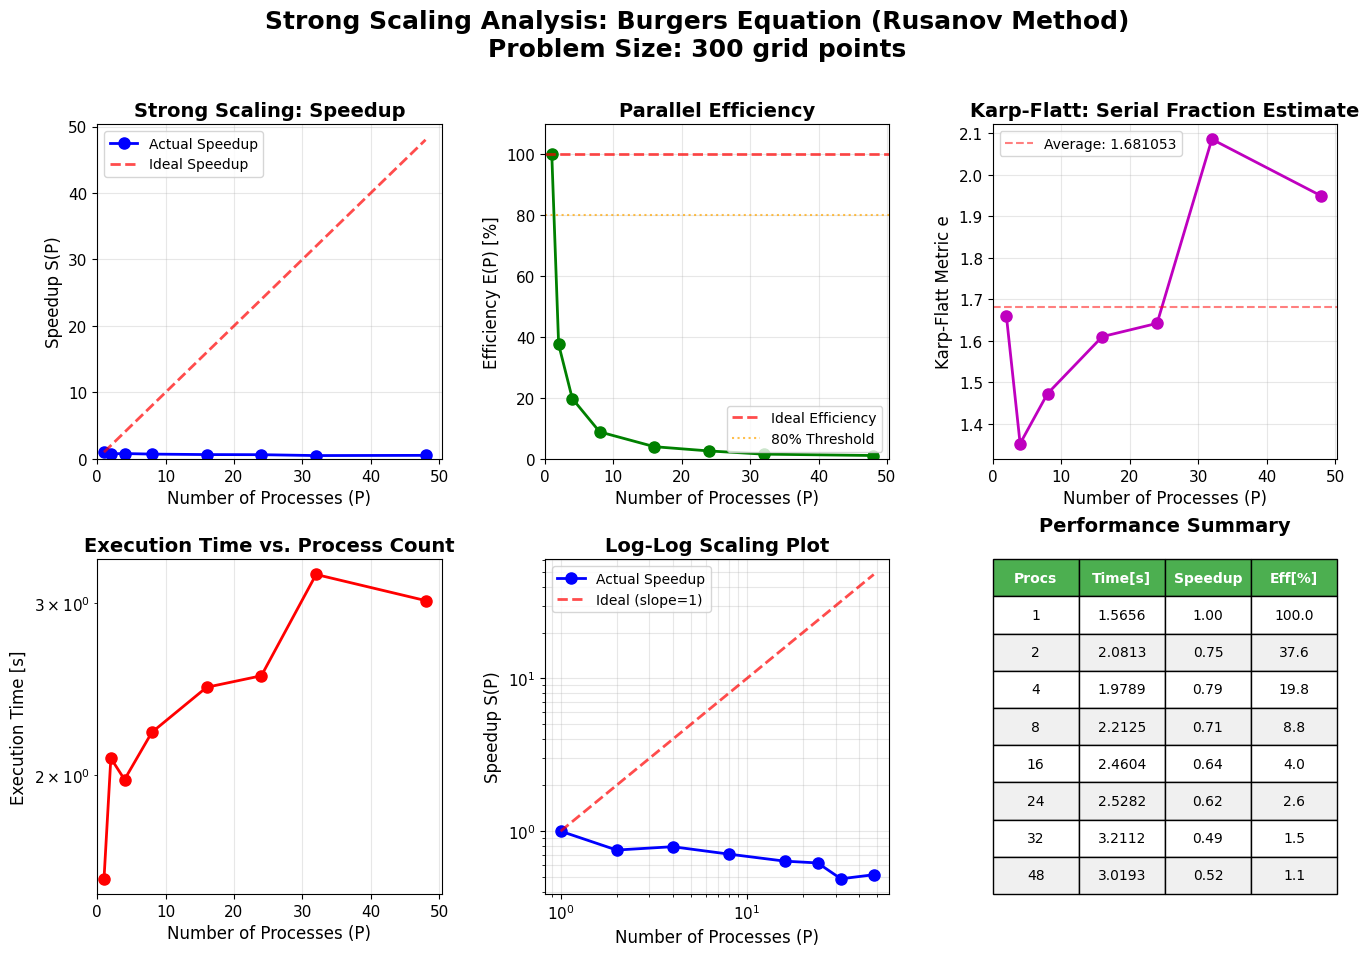

In [5]:
if analyzer.timing_data and 1 in analyzer.timing_data:
    speedup = analyzer.compute_speedup()
    efficiency = analyzer.compute_efficiency()
    karp_flatt = analyzer.compute_karp_flatt()

    n_procs = sorted(speedup.keys())
    speedup_vals = [speedup[p] for p in n_procs]
    efficiency_vals = [efficiency[p] for p in n_procs]

    # Ideal speedup for comparison
    ideal_speedup = n_procs

    # Create figure with subplots
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

    # 1. Speedup (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(n_procs, speedup_vals, 'bo-', linewidth=2, markersize=8,
            label='Actual Speedup')
    ax1.plot(n_procs, ideal_speedup, 'r--', linewidth=2, alpha=0.7,
            label='Ideal Speedup')
    ax1.set_xlabel('Number of Processes (P)', fontsize=12)
    ax1.set_ylabel('Speedup S(P)', fontsize=12)
    ax1.set_title('Strong Scaling: Speedup', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(left=0)
    ax1.set_ylim(bottom=0)

    # 2. Efficiency (top middle)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(n_procs, efficiency_vals, 'go-', linewidth=2, markersize=8)
    ax2.axhline(y=100, color='r', linestyle='--', linewidth=2, alpha=0.7,
               label='Ideal Efficiency')
    ax2.axhline(y=80, color='orange', linestyle=':', linewidth=1.5, alpha=0.7,
               label='80% Threshold')
    ax2.set_xlabel('Number of Processes (P)', fontsize=12)
    ax2.set_ylabel('Efficiency E(P) [%]', fontsize=12)
    ax2.set_title('Parallel Efficiency', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(left=0)
    ax2.set_ylim(bottom=0, top=110)

    # 3. Karp-Flatt metric (top right)
    if len(karp_flatt) > 0:
        ax3 = fig.add_subplot(gs[0, 2])
        kf_procs = sorted(karp_flatt.keys())
        kf_vals = [karp_flatt[p] for p in kf_procs]
        ax3.plot(kf_procs, kf_vals, 'mo-', linewidth=2, markersize=8)
        ax3.set_xlabel('Number of Processes (P)', fontsize=12)
        ax3.set_ylabel('Karp-Flatt Metric e', fontsize=12)
        ax3.set_title('Karp-Flatt: Serial Fraction Estimate', fontsize=14, fontweight='bold')
        ax3.grid(True, alpha=0.3)
        ax3.set_xlim(left=0)

        avg_kf = np.mean(kf_vals)
        ax3.axhline(y=avg_kf, color='red', linestyle='--', alpha=0.5,
                   label=f'Average: {avg_kf:.6f}')
        ax3.legend(fontsize=10)

    # 4. Execution time (bottom left)
    ax4 = fig.add_subplot(gs[1, 0])
    times = [analyzer.timing_data[p] for p in n_procs]
    ax4.plot(n_procs, times, 'ro-', linewidth=2, markersize=8)
    ax4.set_xlabel('Number of Processes (P)', fontsize=12)
    ax4.set_ylabel('Execution Time [s]', fontsize=12)
    ax4.set_title('Execution Time vs. Process Count', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(left=0)
    ax4.set_yscale('log')

    # 5. Speedup on log-log scale (bottom middle)
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.loglog(n_procs, speedup_vals, 'bo-', linewidth=2, markersize=8,
              label='Actual Speedup')
    ax5.loglog(n_procs, ideal_speedup, 'r--', linewidth=2, alpha=0.7,
              label='Ideal (slope=1)')
    ax5.set_xlabel('Number of Processes (P)', fontsize=12)
    ax5.set_ylabel('Speedup S(P)', fontsize=12)
    ax5.set_title('Log-Log Scaling Plot', fontsize=14, fontweight='bold')
    ax5.legend(fontsize=10)
    ax5.grid(True, alpha=0.3, which='both')

    # 6. Performance table (bottom right)
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.axis('off')

    table_data = [['Procs', 'Time[s]', 'Speedup', 'Eff[%]']]
    for p in n_procs:
        row = [
            f"{p}",
            f"{analyzer.timing_data[p]:.4f}",
            f"{speedup[p]:.2f}",
            f"{efficiency[p]:.1f}"
        ]
        table_data.append(row)

    table = ax6.table(cellText=table_data, cellLoc='center', loc='center',
                     bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    # Style header row
    for i in range(4):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Alternate row colors
    for i in range(1, len(table_data)):
        color = '#f0f0f0' if i % 2 == 0 else 'white'
        for j in range(4):
            table[(i, j)].set_facecolor(color)

    ax6.set_title('Performance Summary', fontsize=14, fontweight='bold', pad=20)

    # Overall title
    title = 'Strong Scaling Analysis: Burgers Equation (Rusanov Method)'
    if analyzer.problem_size:
        title += f'\nProblem Size: {analyzer.problem_size} grid points'
    plt.suptitle(title, fontsize=18, fontweight='bold', y=0.995)

    output_file = f'plots/scaling_analysis_nx{grid_size}.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"\nSaved: {output_file}")
    plt.show()
else:
    print("Cannot create plots without timing data!")

## Optional: Analyze Multiple Grid Sizes

If you ran experiments with different grid sizes, compare their scaling behavior.

Loaded timing data for 8 process counts
Loaded timing data for 8 process counts
Loaded timing data for 8 process counts
Saved: plots/scaling_comparison_all_grids.png


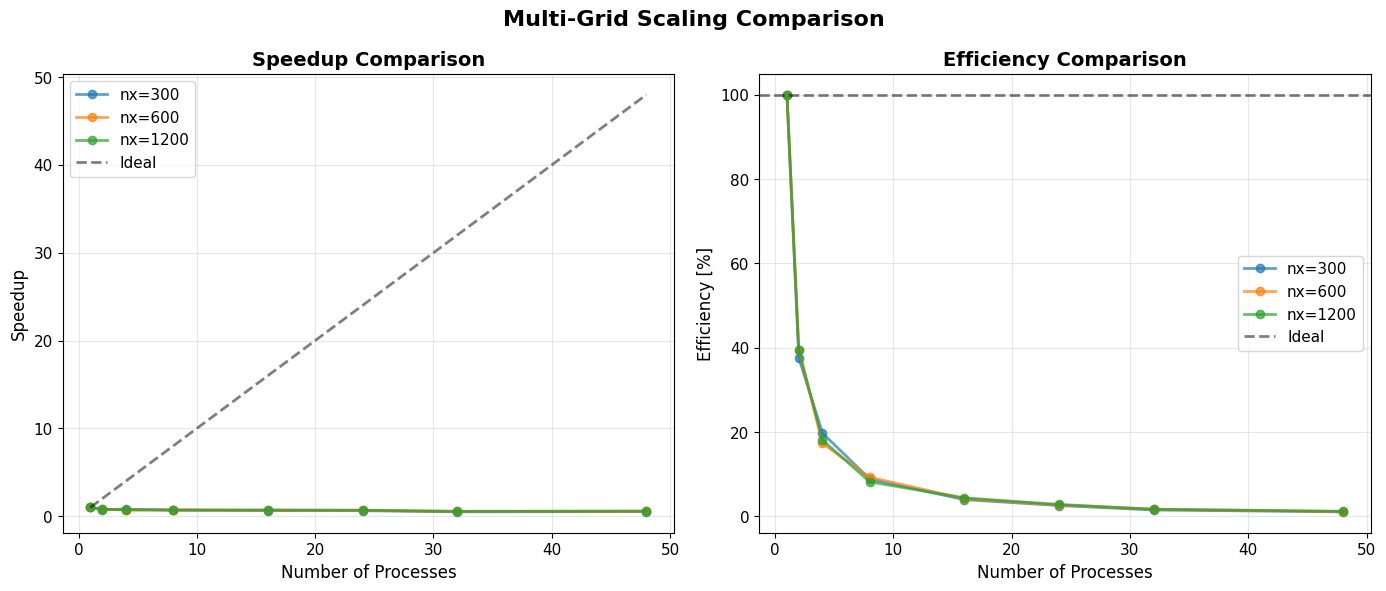

In [6]:
# Analyze multiple grid sizes
grid_sizes = [300, 600, 1200]  # Adjust based on your experiments

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for nx in grid_sizes:
    analyzer_multi = PerformanceAnalyzer()
    analyzer_multi.load_from_npz_files('plgrid_results', nx)  # Use plgrid_results
    
    if analyzer_multi.timing_data and 1 in analyzer_multi.timing_data:
        speedup = analyzer_multi.compute_speedup()
        efficiency = analyzer_multi.compute_efficiency()
        
        n_procs = sorted(speedup.keys())
        speedup_vals = [speedup[p] for p in n_procs]
        efficiency_vals = [efficiency[p] for p in n_procs]
        
        # Speedup comparison
        ax1.plot(n_procs, speedup_vals, 'o-', linewidth=2, markersize=6,
                label=f'nx={nx}', alpha=0.7)
        
        # Efficiency comparison
        ax2.plot(n_procs, efficiency_vals, 'o-', linewidth=2, markersize=6,
                label=f'nx={nx}', alpha=0.7)

# Ideal lines
if n_procs:
    ax1.plot(n_procs, n_procs, 'k--', linewidth=2, alpha=0.5, label='Ideal')
    ax2.axhline(y=100, color='k', linestyle='--', linewidth=2, alpha=0.5, label='Ideal')

ax1.set_xlabel('Number of Processes', fontsize=12)
ax1.set_ylabel('Speedup', fontsize=12)
ax1.set_title('Speedup Comparison', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_xlabel('Number of Processes', fontsize=12)
ax2.set_ylabel('Efficiency [%]', fontsize=12)
ax2.set_title('Efficiency Comparison', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Multi-Grid Scaling Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()

output_file = 'plots/scaling_comparison_all_grids.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Saved: {output_file}")
plt.show()

## Summary

This notebook provides comprehensive performance analysis for the parallel Burgers solver:

### Key Findings
- **Speedup**: How much faster the parallel version runs
- **Efficiency**: How well the code utilizes available processors
- **Scalability**: Whether performance continues to improve with more processes
- **Serial Fraction**: Estimated portion of code that cannot be parallelized

### Expected Behavior
- Good scaling (80%+ efficiency) for 2-8 processes on moderate grids
- Better scaling for larger problems (higher nx)
- Communication overhead becomes significant beyond ~16-32 processes

### Next Steps
- Experiment with larger grid sizes for better parallel efficiency
- Compare different MPI implementations
- Analyze strong vs weak scaling